In [1]:

# Author: Shilin Zhang
# Created Date: 13 June 2022

# Description:
# Replication work of the paper: 
# Optimal selection of time lags for TDSEP based on genetic algorithm

# Related Paper:
# TDSEP - an efficient algorithm for blind separation using time structure

# Method of determning the optimal lag: 
# Indenpendent Component Analysis (ICA)
# Genetic Algorithm (GA)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import yfinance as yf
from numpy.random import randint
from numpy.random import rand

In [3]:
# read the data from csv file
startdate = '2020-01-01'
enddate = '2022-01-01'
datasource = 'SPY'
data = yf.download(datasource,start = startdate,end = enddate)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,323.540009,324.890015,322.529999,324.869995,313.744446,59151200
2020-01-03,321.160004,323.640015,321.100006,322.410004,311.368713,77709700
2020-01-06,320.489990,323.730011,320.359985,323.640015,312.556641,55653900
2020-01-07,323.019989,323.540009,322.239990,322.730011,311.677765,40496400
2020-01-08,322.940002,325.779999,322.670013,324.450012,313.338928,68296000
...,...,...,...,...,...,...
2021-12-27,472.059998,477.309998,472.010010,477.260010,475.781921,56808600
2021-12-28,477.720001,478.809998,476.059998,476.869995,475.393127,47274600
2021-12-29,476.980011,478.559998,475.920013,477.480011,476.001251,54503000


<AxesSubplot:xlabel='Date'>

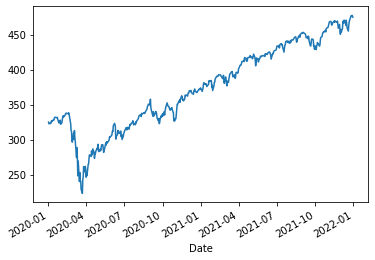

In [5]:
plot.rcParams["figure.figsize"] = (25,6)
data['Close'].plot()

In [6]:
# observations matrix X

from sklearn.preprocessing import MinMaxScaler

cols = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume']
mmscaler = MinMaxScaler()
data[cols] = mmscaler.fit_transform(data[cols])
X = data[cols].to_numpy()
X = X.T

In [7]:
X.shape

(6, 505)

In [8]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

# calculate the covariance matrix of six observed time series
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [9]:
def whiten(X):
    # Calculate the covariance matrix
    covarMatrix = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(covarMatrix)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Z = np.dot(whiteM, X)

    return Z, whiteM

In [10]:
X_center, meanX = center(X)

In [11]:
X_center

array([[-0.20034734, -0.20987728, -0.21256012, ...,  0.41405166,
         0.41785555,  0.4086861 ],
       [-0.20466752, -0.20968116, -0.20932019, ...,  0.41168888,
         0.41345369,  0.40487029],
       [-0.18833066, -0.19387757, -0.19674809, ...,  0.40666551,
         0.40569577,  0.40181679],
       [-0.19170205, -0.20136689, -0.19653441, ...,  0.40787367,
         0.40268761,  0.39797299],
       [-0.20621757, -0.21537542, -0.21079626, ...,  0.41924163,
         0.41416909,  0.4095577 ],
       [-0.07642214, -0.02568297, -0.0859838 , ..., -0.08913037,
        -0.08687208, -0.05978239]])

In [12]:
Z,whiteM = whiten(X_center)

In [13]:
Z

array([[-0.39250303, -0.9344851 , -1.13699236, ...,  0.55530881,
         0.97692057,  0.62668308],
       [-0.70724542, -0.42646435,  0.01689433, ...,  0.48353375,
         0.92579131,  0.3201306 ],
       [-0.05278235,  0.74919622, -0.29754136, ...,  0.98080645,
         0.86700735,  1.56854322],
       [ 1.07092481,  0.71955236,  1.14883753, ...,  0.06964307,
        -0.41316691, -0.27855694],
       [-1.95300838, -2.11130795, -1.85471607, ...,  1.77308904,
         1.48298026,  1.61666353],
       [-0.88431747, -0.49386737, -1.00093975, ...,  0.05731516,
         0.04635926,  0.29182626]])

In [14]:
print(np.round(covariance(Z)))

[[ 1.  0.  0.  0. -0. -0.]
 [ 0.  1. -0.  0. -0. -0.]
 [ 0. -0.  1. -0.  0.  0.]
 [ 0.  0. -0.  1. -0.  0.]
 [-0. -0.  0. -0.  1.  0.]
 [-0. -0.  0.  0.  0.  1.]]


In [15]:
Z.shape

(6, 505)

In [16]:
# Independent Component Analysis
# X = S * A.T
# By using ICA, we could approximate original signal matrix S

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=6,
                      random_state=0,
                      whiten='unit-variance',
                      fun='logcosh')
S = transformer.fit_transform(X.T).T

In [17]:
S.shape

(6, 505)

In [18]:
# Calculate Rotation Matrix Q

# covariance matrix of Z with tau  = Q_T * covariance matrix of S with tau * Q
# TDSEP - an efficient algorithm for blind separation using time structure

# Calculate the average covariance matrix with a list of lags

def covariance_with_lag(x,lag):
    matrix = np.empty((6, 6), float)
    for i in lag:
        x1 = x[:,i:n]
        x2 = x[:,0:n-lag]
        mean1 = np.mean(x1, axis=1, keepdims=True)
        mean1 = np.mean(x2, axis=1, keepdims=True)
        n = np.shape(x1)[1] - 1
        m1 = x1 - mean1
        m2 = x2 - mean2
        matrix = matrix + m1.dot(m2.T)/n
    return matrix/len(lag)

# Compute the orthogonal matrix Q via approximate simultaneous diagonalization

def generate_Q(Z,lag):
    # Set a fixed Q for testing
    Q = np.array([[1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1],
     [1,1,1,1,1,1]])
    return Q

In [19]:
# Negentropy Estimation

# One of the estimation function G1 
def G(x):
    return 1/a_1 * np.cosh(a_1 * x)

def J(Y):
    row,col = Y.shape
    J = 0
    for i in range(0,col):
        sum1 = 0
        sum2 = 0
        for j in Y[:,i]:
            sum1 = sum1 + G(j)
            v = np.random.normal(0,1)
            sum2 = sum2 + + G(v)
        E_Y = sum1/row
        E_V = sum2/row
        J = J + (E_Y - E_V) ** 2
    return J

In [20]:
# genetic algorithm search for optimization problem


# objective function
def obj(x):
    Q = generate_Q(Z,x)
    Y = Q @ Z
    result  = n_d * J(Y)/sum(x)
    return -result

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

In [21]:
# genetic algorithm

def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(pop[0])
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                # print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
                print("iteration: %d, number of lags: %d, score: %.3f" %(gen, sum(pop[i]), scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [22]:
# Parameter Setting

# length of an individual/ maximum tau
n_d = 100
# number of generation
n_g = 500
# number of population
n_p = 100
# crossover prob
p_c = 0.85
# mutation prob
p_m = 0.05

# parameter for negentropy estimation
a_1 = 1.5


In [23]:
best, score = genetic_algorithm(obj, n_d, n_g, n_p, p_c, p_m)
print('Done!')
print('f(%s) = %f' % (best, score))

iteration: 0, number of lags: 44, score: -10160503.497
iteration: 0, number of lags: 44, score: -10206378.015
iteration: 0, number of lags: 41, score: -10941102.405
iteration: 0, number of lags: 39, score: -11481632.138
iteration: 0, number of lags: 38, score: -11803468.976
iteration: 1, number of lags: 37, score: -12102687.373
iteration: 1, number of lags: 37, score: -12136415.735
iteration: 2, number of lags: 36, score: -12472818.709
iteration: 2, number of lags: 35, score: -12812308.177
iteration: 3, number of lags: 34, score: -13189435.444
iteration: 3, number of lags: 33, score: -13571405.644
iteration: 3, number of lags: 33, score: -13609545.271
iteration: 4, number of lags: 32, score: -14020546.550
iteration: 4, number of lags: 31, score: -14453097.726
iteration: 4, number of lags: 29, score: -15426424.331
iteration: 5, number of lags: 29, score: -15431697.866
iteration: 5, number of lags: 29, score: -15472372.774
iteration: 5, number of lags: 28, score: -16040557.226
iteration:

In [24]:
table = pd.DataFrame(best,columns = ['lag'])

best_lag_list = []
for i in range(0,100):
    if table.iloc[i][0] == 1:
        best_lag_list.append(i+1)
        
best_lag_list

[8, 9, 17, 21, 22, 29, 70, 73, 74, 97, 99]